# Compare volumes
This [Jupyter](http://jupyter.com) notebook was used to compare the acinar volumes obtained with the automatic segmentation with the ones obtained with the stereological estimation.
This led us to only use the stereologically estimated data in our [publication on the acinar complexity](https://www.authorea.com/274247/47HwqAxume3L2xkLOsg_SQ).

In [1]:
# Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import re
import timeit

In [2]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [3]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook'
      % the_current_git_hash)

We are working with version ca60e7b of the analyis notebook


In [4]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.transparent'] = True  # Save figures with transparent background

In [5]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
imgdir = os.path.join('Output', the_current_git_hash)
os.makedirs(imgdir, exist_ok=True)

Load the volume data directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
After doing that, we save it to a dataframe on disk, since looking for all the DICOM files takes nearly an hour...

In [6]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
terastation = drive + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [7]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Volumes = 'VolumesFromDisk_' + get_git_hash() + '.pkl'

In [8]:
# Use the *newest* VolumesFromDisk file, even if it's from another git hash
try:
    OutputName_Volumes = max(glob.iglob('VolumesFromDisk*.pkl'), key=os.path.getctime)
except ValueError:
    print('We probably could not find a VolumesFromDisk*.pkl file...')
    print('Run "Analysis.ipynb" file to regenerate it.')

In [9]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
# This takes between 30 and 60 minutes!!!
# We thus only do it if we cannot read the dataframe with all the data that we save later on...
if os.path.exists(OutputName_Volumes):
    print('We load the data from %s' % OutputName_Volumes)
else:
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We load the data from VolumesFromDisk_2ca705f.pkl


In [10]:
# Collect the data into a dataframe
if os.path.exists(OutputName_Volumes):
    # We already did it once, so just load it...
    VolumesFromDisk = pandas.read_pickle(OutputName_Volumes)
else:
    # Save the file locations into an empty dataframe
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [11]:
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'.
    # To get cm³ we divide by 1000
    VolumesFromDisk['Volume'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0]) / 1000
                                 for f in AcinarVolumeFiles]  # cm³

In [12]:
# Save the data and give some feedback.
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)
print('We have %s acini where we have volumes' % len(VolumesFromDisk))

We have 701 acini where we have volumes


In [13]:
# Drop Day 36
# https://stackoverflow.com/a/27360130/323100
VolumesFromDisk.drop(VolumesFromDisk[VolumesFromDisk['Day'] == 36].index, inplace=True)

In [14]:
# Drop Day 36, wSave the data and give some feedback.
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)
print('If we drop day 36, we now have %s acini' % len(VolumesFromDisk))

If we drop day 36, we now have 701 acini


In [15]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors = seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

In [16]:
VolumesFromDisk.head()

,Location_Volume,Filename_Volume,Animal,Beamtime,Day,Acinus,Volume_Acinus_MeVisLab
0,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus1.volu...,21A,2009f,21,1,0.018194
1,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus11.vol...,21A,2009f,21,11,0.019022
2,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus12.vol...,21A,2009f,21,12,0.082790
3,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus16.vol...,21A,2009f,21,16,0.031000
4,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus17.vol...,21A,2009f,21,17,0.086996


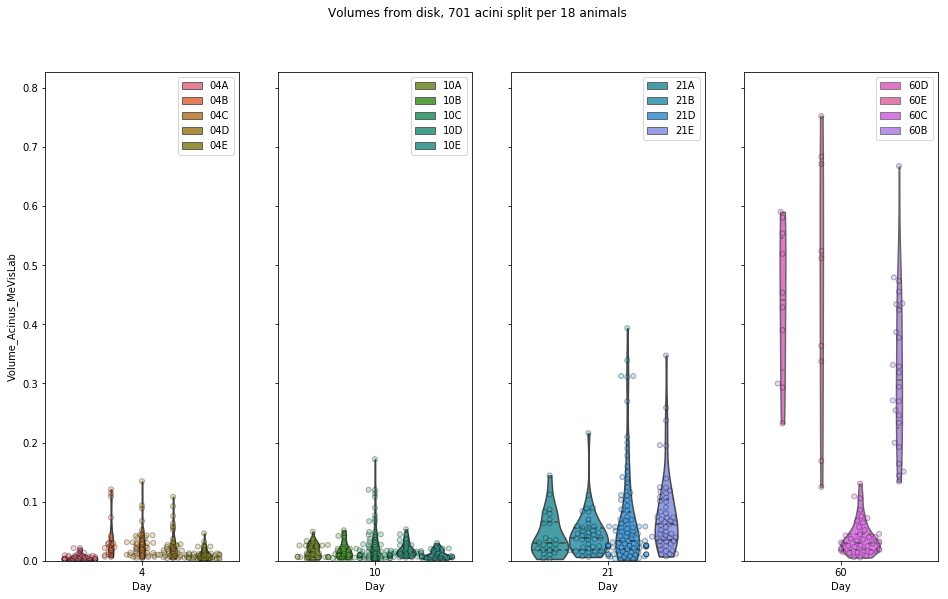

In [17]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                               x='Day',
                               y='Volume_Acinus_MeVisLab',
                               hue='Animal',
                               palette=ourpalette,
                               cut=0,
                               inner='quartiles')
    swrmplt = seaborn.swarmplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                                x='Day',
                                y='Volume_Acinus_MeVisLab',
                                hue='Animal',
                                dodge=True,
                                linewidth=1,
                                palette=ourpalette,
                                edgecolor='k',
                                alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * VolumesFromDisk.Volume_Acinus_MeVisLab.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
    if c:
        plt.gca().set_yticklabels([])
        plt.gca().set_ylabel('')
plt.suptitle('Volumes from disk, %s acini split per %s animals' % (len(VolumesFromDisk),
                                                                   len(pandas.unique(VolumesFromDisk.Animal))))
plt.savefig(os.path.join(imgdir, 'volume-dicom.png'), bbox_inches='tight')
plt.show()

In [18]:
# We copied everything from nas_schittny and the terastation to 'fast SSD'.
# Load the data from there
if 'debian' in platform.dist():
    drive = '/media/habi/Fast_SSD/'
else:
    drive = 'F:/'
# Load the data from this folder
RootPath = drive + os.path.join('Acini')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [19]:
StepanizerFiles_David = sorted(glob.glob(os.path.join(RootPath, '**/*2018*.xls'), recursive=True))

In [20]:
David = pandas.DataFrame({'Location_David': StepanizerFiles_David})
David['Filename'] = [os.path.basename(f) for f in StepanizerFiles_David]
David['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_David]
David['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_David]
David['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_David]
David['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_David]
David['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_David]

In [21]:
David['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles_David]

In [22]:
David['Area per point'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=28, header=None, usecols=[0, 1],
                                                 nrows=1)[1][0]) for f in StepanizerFiles_David]

In [23]:
David['Volume'] = [cts * ap * 2 * 7.4 / 1e9 for cts, ap in zip(David['Counts'], David['Area per point'])]

In [24]:
for d in sorted(David['Day'].unique()):
    print('The mean (stepanizered) volume at day %02d is %.4g' % (d, David.loc[David.Day == d]['Volume'].mean()))

The mean (stepanizered) volume at day 04 is 0.03286
The mean (stepanizered) volume at day 10 is 0.04004
The mean (stepanizered) volume at day 21 is 0.1039
The mean (stepanizered) volume at day 60 is 0.5214


In [25]:
for d in sorted(VolumesFromDisk['Day'].unique()):
    print('The mean (MeVisLab) volume at day %02d is %.4g' % (d,
                                                              VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Volume_Acinus_MeVisLab'].mean()))

The mean (MeVisLab) volume at day 04 is 0.01949
The mean (MeVisLab) volume at day 10 is 0.02068
The mean (MeVisLab) volume at day 21 is 0.06365
The mean (MeVisLab) volume at day 60 is 0.2112


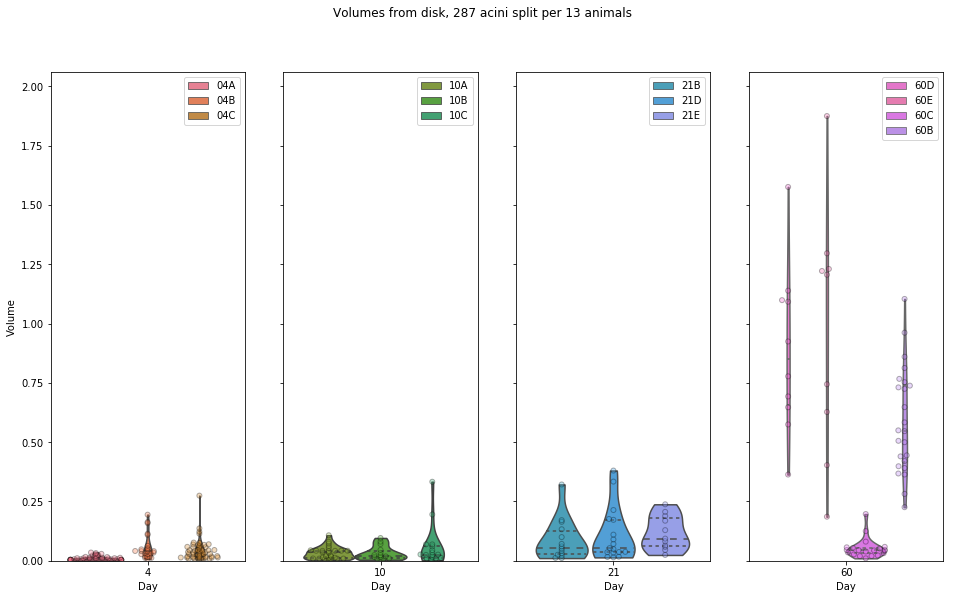

In [26]:
for c, d in enumerate(sorted(pandas.unique(David.Day))):
    plt.subplot(1, len(pandas.unique(David.Day)), c + 1)
    bxplt = seaborn.violinplot(data=David.loc[David.Day == d], x='Day', y='Volume',
                               hue='Animal', palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=David.loc[David.Day == d], x='Day', y='Volume',
                                hue='Animal', dodge=True, linewidth=1, palette=ourpalette, edgecolor='k',
                                alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * David.Volume.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
    if c:
        plt.gca().set_yticklabels([])
        plt.gca().set_ylabel('')
plt.suptitle('Volumes from disk, %s acini split per %s animals' % (len(David),
                                                                   len(pandas.unique(David.Animal))))
plt.savefig(os.path.join(imgdir, 'volume-stepanizer.png'), bbox_inches='tight')
plt.show()

In [27]:
VolumesFromDisk.head()

,Location_Volume,Filename_Volume,Animal,Beamtime,Day,Acinus,Volume_Acinus_MeVisLab
0,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus1.volu...,21A,2009f,21,1,0.018194
1,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus11.vol...,21A,2009f,21,11,0.019022
2,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus12.vol...,21A,2009f,21,12,0.082790
3,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus16.vol...,21A,2009f,21,16,0.031000
4,\\anatera4\share\SLS\2009f\mrg\R108C21A2t-mrg\...,R108C21A2t-mrg.2240.2940.1024.gvr.acinus17.vol...,21A,2009f,21,17,0.086996


In [28]:
David.head()

,Location_David,Filename,Beamtime,Sample,Animal,Day,Acinus,Counts,Area per point,Volume
0,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2018-01-26_12-57_resul...,2009f,R108C60Dt-mrg,60D,60,3,526,141125.44,1.098633
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus04_2018-02-26_16-09_resul...,2009f,R108C60Dt-mrg,60D,60,4,816,130478.41,1.575762
2,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus07_2018-02-23_12-47_resul...,2009f,R108C60Dt-mrg,60D,60,7,938,46612.98,0.647100
3,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus09_2018-02-27_15-16_resul...,2009f,R108C60Dt-mrg,60D,60,9,953,55127.13,0.777535
4,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus10_2018-02-26_16-28_resul...,2009f,R108C60Dt-mrg,60D,60,10,814,47703.30,0.574691


Now we 'just' have to concatenate the two dataframes :)

In [29]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Merged = 'Merged_' + get_git_hash() + '.pkl'

In [30]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
Merged = pandas.merge(David, VolumesFromDisk,
                      on=['Animal', 'Acinus', 'Day', 'Beamtime'],
                      how='inner',
                      suffixes=('_from_david', '_from_mevis'))

In [31]:
# Volume ratio
Merged['Volume ratio'] = [david / mevis for david, mevis in zip(Merged['Volume'],
                                                                Merged['Volume_Acinus_MeVisLab'])]

In [32]:
Merged['Volume ratio'].mean()

1.651856523330491

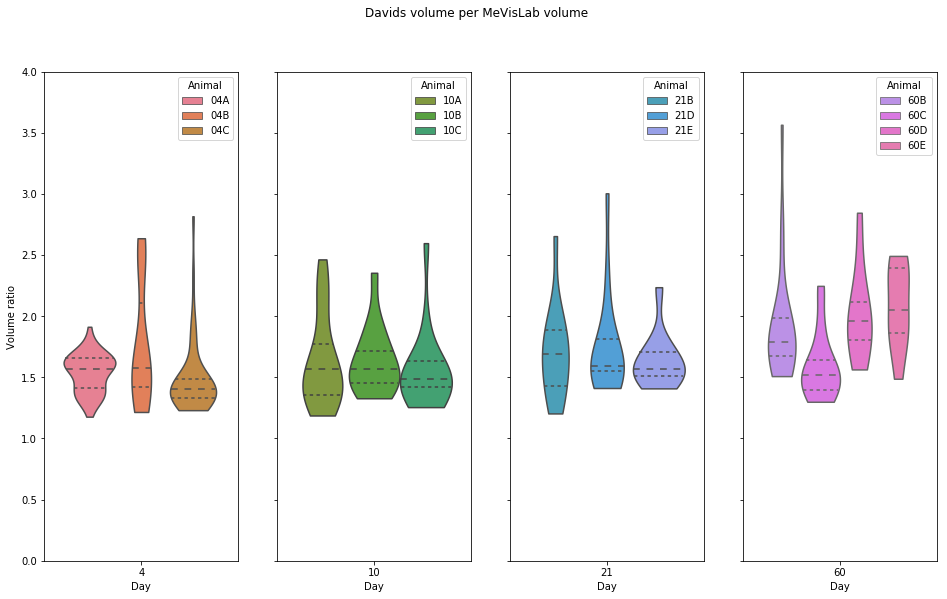

In [33]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='Volume ratio',
                       hue='Animal',
                       hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                       palette=ourpalette, cut=0, inner='quartiles')
    plt.ylim([0, 4])
    if c:
        plt.gca().set_yticklabels([])
        plt.gca().set_ylabel('')
plt.suptitle('Davids volume per MeVisLab volume')
plt.show()

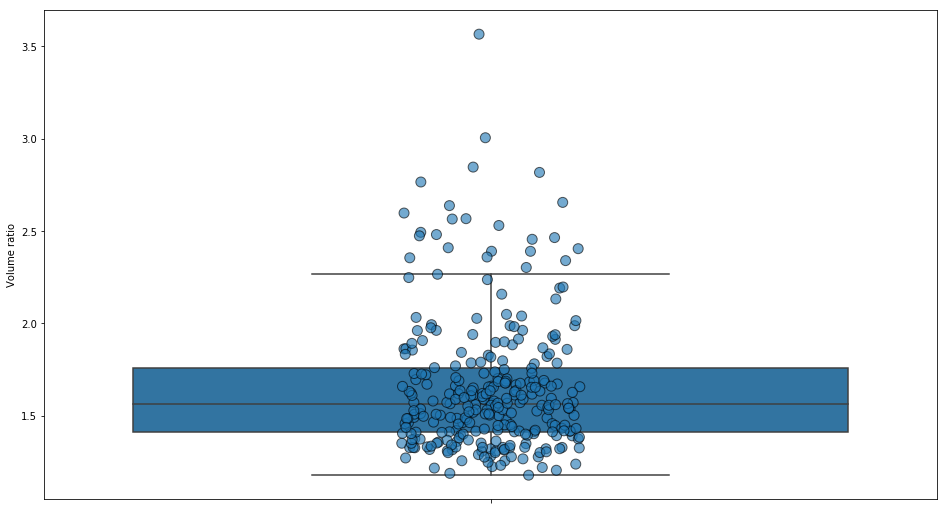

In [34]:
seaborn.stripplot(data=Merged, y='Volume ratio', linewidth=1, edgecolor='k', s=10, alpha=0.618, jitter=True)
seaborn.boxplot(data=Merged, y='Volume ratio', fliersize=0)
plt.show()

In [35]:
# To assess the 'outliers' and (potentially) delete the files for recounting, display the *full* content of the dataframe, without truncating it
pandas.set_option('display.max_colwidth', -1)

In [36]:
# Biggest
Merged.sort_values('Volume ratio', ascending=False)[['Location_David',
                                                     'Sample',
                                                     'Animal',
                                                     'Acinus',
                                                     'Volume ratio']].head(n=3)

,Location_David,Sample,Animal,Acinus,Volume ratio
270,/media/habi/Fast_SSD/Acini/2010c_tape/R108C60B_B1_mrg_10c/acinus09/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C60B_B1_mrg-acinus09_2018-03-06_10-38_result.xls,R108C60B_B1_mrg,60B,9,3.565059
244,/media/habi/Fast_SSD/Acini/2010c_tape/R108C21D_B1_mrg_10c/acinus53/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C21D_B1_mrg-acinus53_2018-02-23_18-04_result.xls,R108C21D_B1_mrg,21D,53,3.004597
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt-mrg/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C60Dt-mrg-acinus04_2018-02-26_16-09_result.xls,R108C60Dt-mrg,60D,4,2.845803


In [37]:
# Smallest
Merged.sort_values('Volume ratio', ascending=True)[['Location_David',
                                                    'Sample',
                                                    'Animal',
                                                    'Acinus',
                                                    'Volume ratio']].head(n=3)

,Location_David,Sample,Animal,Acinus,Volume ratio
20,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At-mrg/acinus12/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C04At-mrg-acinus12_2018-03-06_12-46_result.xls,R108C04At-mrg,04A,12,1.178378
161,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10At-mrg/acinus37/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C10At-mrg-acinus37_2018-03-06_12-49_result.xls,R108C10At-mrg,10A,37,1.188181
188,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C21Bt-mrg/acinus14/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/_R108C21Bt-mrg-acinus14_2018-01-29_11-57_result.xls,R108C21Bt-mrg,21B,14,1.204928
